In [1]:
import pandas as pd
import pyBigWig
import numpy as np

In [2]:
def get_cts(peaks_df, bw, width):
    vals = []
    for i, r in peaks_df.iterrows():
        val = np.nan_to_num(bw.values(r['chr'], 
                                            r['start'] + r['summit'] - width//2,
                                            r['start'] + r['summit'] + width//2))
        if len(val) == width:
            vals.append(val)
    return np.array(vals)

In [3]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]


In [5]:
bedf = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/interpret/GM12878.interpreted_regions.bed", sep='\t', names=NARROWPEAK_SCHEMA)
gm12878_bed = bedf.sort_values('5',ascending = False).head(10000)

In [7]:
#gm12878_bed


In [8]:
gm12878_bed.shape

(10000, 10)

In [11]:
cts_bw_file="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/interpret/merged.GM12878.profile.bw"
bias_corrected_bw = pyBigWig.open(cts_bw_file)


In [12]:
bias_corrected_vals = get_cts(gm12878_bed, bias_corrected_bw, width=500)
#f = open("footprints_top.npy", "wb")
#np.save(f , bias_corrected_vals)

In [41]:
import seaborn as sns
import os
#import util
#import moods
import h5py
#import viz_sequence
import numpy as np
import pandas as pd
import pomegranate
import sklearn.cluster
import scipy.cluster.hierarchy
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import subprocess
import vdom.helpers as vdomh
from IPython.display import display
import tqdm

In [52]:
def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

def plot_motif_cooccurrence_heatmaps(pval_matrix):
    """
    Plots a heatmap showing the number of peaks that have both types of
    each motif, as well as a heatmap showing the p-value of co-occurrence.
    """
    num_motifs = pval_matrix.shape[0]
    num_clusters = 20
    print(pval_matrix.shape)

    # Cluster by p-value
    inds = cluster_matrix_indices(pval_matrix, num_clusters)
    cluster_means = np.zeros((num_clusters,pval_matrix.shape[1]))
    for idx in range(num_clusters):
        print(pval_matrix[inds==idx].mean(0).shape)
        cluster_means[idx,:] = pval_matrix[inds==idx].mean(0)
        print(np.sum(cluster_means[idx,:]))
    # Plot the p-value matrix

    fig_width = 5
    fig, ax = plt.subplots(figsize=(500, 100))
    
    # Replace 0s with minimum value (we'll label them properly later)
    #zero_mask = pval_matrix == 0
    #min_val = np.min(pval_matrix[~zero_mask])
    #pval_matrix[zero_mask] = min_val
    logpval_matrix = cluster_means
    
    hmap = ax.imshow(logpval_matrix)

    #ax.set_xticks(np.arange(num_motifs))
    #ax.set_yticks(np.arange(num_motifs))
    #ax.set_xticklabels(motif_keys, rotation=90)
    #ax.set_yticklabels(motif_keys)

    # Loop over data dimensions and create text annotations.
    #for i in range(num_motifs):
    #    for j in range(num_motifs):
    #        if zero_mask[i, j]:
    #            text = "Inf"
    #        else:
    #            text = "%.2f" % np.abs(logpval_matrix[i, j])
    #        ax.text(j, i, text, ha="center", va="center")
    #fig.colorbar(hmap, orientation="horizontal")

    #ax.set_title("-log(p) significance of peaks with both motifs")
    fig.tight_layout()
    plt.show()


In [53]:
plot_motif_cooccurrence_heatmaps(np.array(bias_corrected_vals))

(10000, 500)
(500,)
0.16205541410833035
(500,)
0.3053247228187388
(500,)
0.26537237993645135
(500,)
0.2887341666065595
(500,)
0.19093057268009872
(500,)
0.20858032690989603
(500,)
0.23938771162579542
(500,)
0.31832043559279555
(500,)
0.24370563423619274
(500,)
0.0507131657779496
(500,)
0.22507628706478044
(500,)
0.17046164396244023
(500,)
0.08960094950523967
(500,)
0.2508188262324893
(500,)
0.06005452410090584
(500,)
0.10701697606987182
(500,)
0.03841431797502537
(500,)
0.1220013631295842
(500,)
0.12862912206381338
(500,)
0.13723374703911873


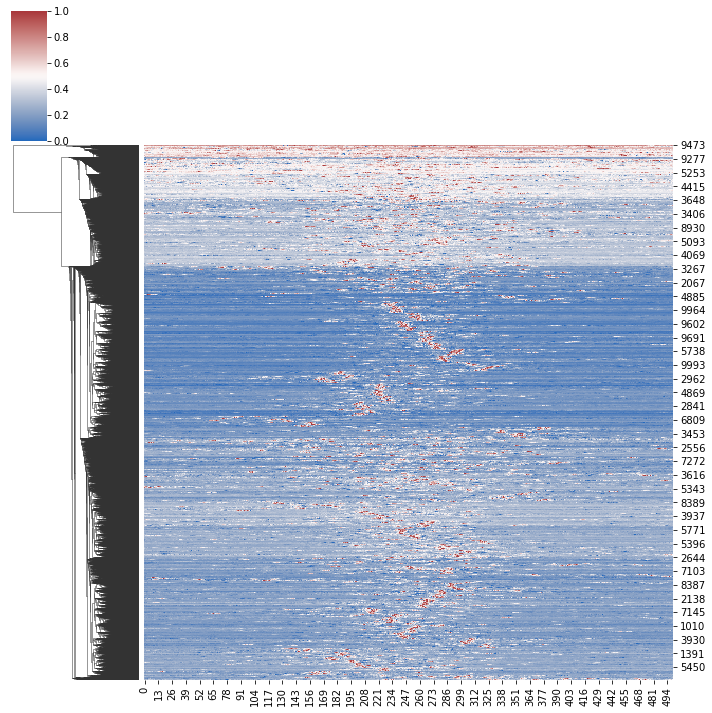

In [44]:
g = sns.clustermap(bias_corrected_vals, standard_scale=0, cmap="vlag", col_cluster=False)

In [10]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(bias_corrected_vals[3671,])